In [435]:
import numpy as np
import pandas as pd
import codecs
import re
import gensim
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

# Задание 1

In [436]:
with codecs.open('./Master_and_Margarita.txt', encoding = 'ANSI', mode = 'r') as f:    
    docs = f.readlines()


def remove_punct_marks(sentence):
 
    sentence = re.sub('[^ a-zа-яё-]', '', sentence, flags = re.IGNORECASE)
    sentence = re.sub(" +", " ", sentence, flags = re.IGNORECASE)

    sentence = sentence.strip()
    sentence = sentence.strip('-')

    return sentence


sentences = [remove_punct_marks(sent) for doc in docs for sent in doc.split('.')]
sentences = [[word for word in sent.lower().split()] for sent in sentences]

word_model = gensim.models.Word2Vec(sentences, vector_size = 100, min_count = 1, window = 5, epochs = 100)

print('Похожие слова:') 
for word in ['пилат','азазелло', 'воланд', 'человек', 'охрана', 'люди']:
    
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

Похожие слова:
  пилат -> прокуратор (0.69), арестант (0.63), врач (0.61), левий (0.56), игемон (0.54), гость (0.53), рюхин (0.52), нервно (0.52)
  азазелло -> бегемот (0.48), воланд (0.45), вошедший (0.45), мастер (0.45), мессир (0.45), рыжий (0.45), служащий (0.45), коровьев (0.43)
  воланд -> мастер (0.59), стравинский (0.50), покровительственно (0.49), пилат (0.47), проницательно (0.47), врач (0.47), отдай (0.46), коровьев (0.46)
  человек -> плаще (0.49), бывает (0.48), круглолицый (0.47), повеса (0.46), военном (0.45), молодой (0.43), багряном (0.43), белом (0.42)
  охрана -> обстреляла (0.79), стерегущая (0.79), упустила (0.72), дымовые (0.72), мертва (0.70), полученная (0.70), возвращает (0.70), занимала (0.70)
  люди -> добрые (0.64), молодые (0.64), развитые (0.62), культурные (0.61), стопками (0.59), деловые (0.59), ходят (0.58), рассыпались (0.58)


# Задание 2

In [437]:
df = pd.read_csv('./production.csv')

x_data = []
y_data = []
data_tst = []

for col in ['Liquid', 'Gas', 'Water']:

    col = df.groupby('API')[col].apply(lambda df_: df_.reset_index(drop = True))

    df_prod = col.unstack()
    data = df_prod.values
  
    data = data / data.max()
    data = data[:, :, np.newaxis]
    data_tr = data[:40]
    data_tst.append(data[40:])

    new_x_data = [data_tr[:, i : i + 12] for i in range(11)]
    x_data.append(np.concatenate(new_x_data, axis = 0))
 
    new_y_data = [data_tr[:, i + 1 : i + 13] for i in range(11)]
    y_data.append(np.concatenate(new_y_data, axis = 0))

x_data = np.concatenate(x_data, axis = 2)
y_data = np.concatenate(y_data, axis = 2)
data_tst = np.concatenate(data_tst, axis = 2)

print(x_data.shape, y_data.shape)

(440, 12, 3) (440, 12, 3)


In [438]:
tensor_x = torch.Tensor(x_data) # transform to torch tensor
tensor_y = torch.Tensor(y_data)

oil_dataset = TensorDataset(tensor_x, tensor_y) # create your dataset
oil_dataloader = DataLoader(oil_dataset, batch_size = 16) # create your dataloader

In [439]:
class OilModel(nn.Module):

    def __init__(self, units = 32):
        super().__init__()

        self.lstm1 = nn.LSTM(3, units, 2, batch_first = True)
        self.dense = nn.Linear(units, 3)
        self.relu = nn.ReLU()
        
    def forward(self, x):

        h, _ = self.lstm1(x)
        outs = []

        for i in range(h.shape[0]):
            outs.append(self.relu(self.dense(h[i])))
            
        out = torch.stack(outs, dim = 0)
        return out

In [440]:
model = OilModel()
opt = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [441]:
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    num = 0
    
    for x_t, y_t in oil_dataloader:
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(x_t)

        loss = criterion(outputs, y_t)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.item()
        num += 1
        
    if epoch % 10 == 9:    
        print(f'[Epoch: {epoch + 1:2d}] loss: {running_loss / num:.3f}')

print('Finished Training')

[Epoch: 10] loss: 0.011
[Epoch: 20] loss: 0.011
[Epoch: 30] loss: 0.011
[Epoch: 40] loss: 0.011
[Epoch: 50] loss: 0.011
[Epoch: 60] loss: 0.011
[Epoch: 70] loss: 0.011
[Epoch: 80] loss: 0.011
[Epoch: 90] loss: 0.011
[Epoch: 100] loss: 0.011
Finished Training


In [442]:
# Предскажем на год вперёд используя данные только первого года
tst = data_tst[:, :12]
predicts = np.zeros((tst.shape[0], 0, tst.shape[2]))

for i in range(1):
    
    x = np.concatenate((tst[:, i:], predicts), axis = 1)
    x_t = torch.from_numpy(x).float()
    pred = model(x_t).detach().numpy()
    last_pred = pred[:, :-1]  # Нас интересует только последний месяц
    predicts = np.concatenate((predicts, last_pred), axis = 1)

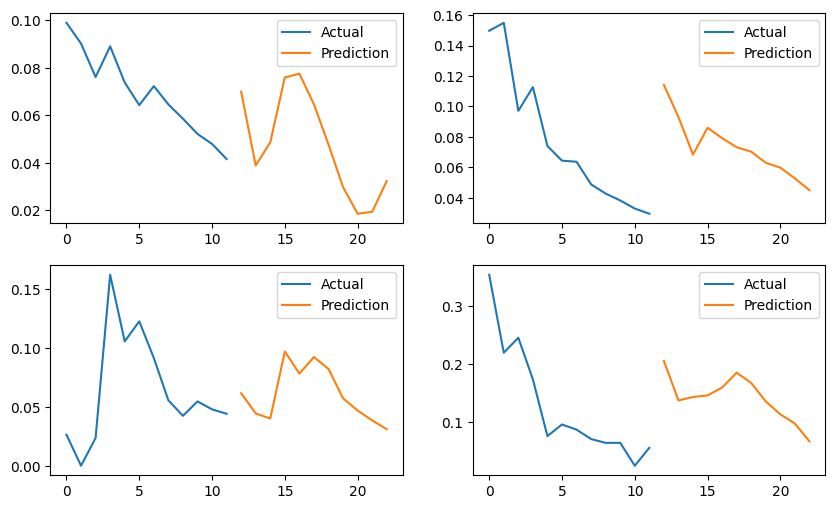

In [443]:
plt.figure(figsize = (10, 6))

for iapi in range(4):

    plt.subplot(2, 2, iapi + 1)
    plt.plot(np.arange(tst.shape[1]), tst[iapi, :, 0], label = 'Actual')
    plt.plot(np.arange(predicts.shape[1]) + tst.shape[1], predicts[iapi, :, 0], label = 'Prediction')
    plt.legend()

plt.show()

# Задание 3

In [444]:
alphabet = set(' -абвгдеёжзийклмнопрстуфхцчшщъыьэюя')

def text_get_dummies(sentences):

    text = ""

    for i in range(len(sentences)):
        text += sentences[i]

    diff = alphabet - set(text)
    dummies = pd.get_dummies(list(text))

    for char in diff:
        dummies[char] = np.zeros(dummies.shape[0], dtype = 'uint8')

    return dummies[sorted(dummies.columns)]


In [445]:
sentence_len = 69

sentences = [remove_punct_marks(sent) for doc in docs for sent in doc.split('.')]
sentences = [sent.lower() for sent in sentences if len(sent) == sentence_len]

dummies = text_get_dummies(sentences)
data = np.array(dummies).reshape(len(sentences), sentence_len, -1)

chars = {i : list(dummies)[i] for i in range(dummies.shape[1])}

print('Количество предложений:', len(sentences))
print('Общее количество символов в тексте', dummies.shape[0])
print('Форма обучающих данных:', data.shape)
print(chars)
dummies

Количество предложений: 66
Общее количество символов в тексте 4554
Форма обучающих данных: (66, 69, 35)
{0: ' ', 1: '-', 2: 'а', 3: 'б', 4: 'в', 5: 'г', 6: 'д', 7: 'е', 8: 'ж', 9: 'з', 10: 'и', 11: 'й', 12: 'к', 13: 'л', 14: 'м', 15: 'н', 16: 'о', 17: 'п', 18: 'р', 19: 'с', 20: 'т', 21: 'у', 22: 'ф', 23: 'х', 24: 'ц', 25: 'ч', 26: 'ш', 27: 'щ', 28: 'ъ', 29: 'ы', 30: 'ь', 31: 'э', 32: 'ю', 33: 'я', 34: 'ё'}


,,-,а,б,в,г,д,е,ж,з,...,ч,ш,щ,ъ,ы,ь,э,ю,я,ё
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4550,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Задание 4

In [446]:
class Letter_Model(nn.Module):

    def __init__(self, units = 100):
        super().__init__()

        self.lstm1 = nn.LSTM(len(alphabet), units, 2, batch_first = True)
        self.dense = nn.Linear(units, len(alphabet))
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        h, _ = self.lstm1(x)
        outs = []

        for i in range(h.shape[0]):
            outs.append(self.relu(self.dense(h[i])))
        
        out = torch.stack(outs, dim = 0)
        return out

In [447]:
model = Letter_Model()
opt = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [448]:
x_data = [data[:, i : i + 7] for i in range(62)]
x_data = np.concatenate(x_data, axis = 0)
 
y_data = [data[:, i + 1 : i + 8] for i in range(62)]
y_data = np.concatenate(y_data, axis = 0)

print(np.array(x_data).shape, np.array(y_data).shape)

(4092, 7, 35) (4092, 7, 35)


In [449]:
tensor_x = torch.Tensor(x_data) # transform to torch tensor
tensor_y = torch.Tensor(y_data)

letter_dataset = TensorDataset(tensor_x, tensor_y) # create your dataset
letter_dataloader = DataLoader(letter_dataset, batch_size = 100) # create your dataloader

In [450]:
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    num = 0
    
    for x_t, y_t in letter_dataloader:
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(x_t)
        loss = criterion(outputs, y_t)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.item()
        num += 1
    
    if epoch % 10 == 9:
        print(f'[Epoch: {epoch + 1:3d}] loss: {running_loss / num:.6f}')

print('Finished Training')

[Epoch:  10] loss: 0.024261
[Epoch:  20] loss: 0.022243
[Epoch:  30] loss: 0.019342
[Epoch:  40] loss: 0.017292
[Epoch:  50] loss: 0.016008
[Epoch:  60] loss: 0.015389
[Epoch:  70] loss: 0.014976
[Epoch:  80] loss: 0.014768
[Epoch:  90] loss: 0.014665
[Epoch: 100] loss: 0.014555
Finished Training


In [453]:
tst = ['печа', 'отве', 'приг', 'закр', 'берл']
dummies = text_get_dummies(tst)
dummies = np.array(dummies).reshape(len(tst), 4, -1)

for i_word in range(len(tst)):

    print(tst[i_word], end = '')
    predicts = np.zeros((dummies.shape[0], 0, dummies.shape[2]))

    for i in range(4):

        x = np.concatenate((dummies[:, i:], predicts), axis = 1)
        x_t = torch.from_numpy(x).float()
        
        pred = model(x_t).detach().numpy()
        last_pred = pred[:, -1:]

        predicts = np.concatenate((predicts, last_pred), axis = 1)

    for i_char in range(predicts.shape[1]): 

        df = pd.DataFrame(predicts[i_word][i_char])

        ids = df[df.ne(0)].stack().reset_index()

        if ids.shape[0] != 0:
            print(chars[ids['level_0'][ids[0].idxmax()]], end = '')
        
        else:
            print('?', end = '')

    print()

печаг ??
ответил 
пригласи
закрыл с
берли ? 
